In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os
from common import *
import pandas as pd
#from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Lasso, Ridge, LinearRegression

os.chdir("../")
print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

%matplotlib inline 

Root directory: c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project1\FYS-STK4155-Prj1_report


### Global variables 

In [2]:
INPUT_DATA = "data/input_data/"  # Path for input data
REPORT_DATA = "data/report_data/" # Path for data ment for the report
REPORT_FIGURES = "figures/" # Path for figures ment for the report

#  Franke function 3D preview
First we plot a 3D plot of the franke function.
The plot is based on the provided code in the assignmentext for plotting the franke function 

In [ ]:
# Preview plot of the franke function
%matplotlib
np.random.seed(4155)
y = x = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)
z = FrankeFunction(x, y)
noise_mesh = 0.05 * np.random.randn(z.shape[0], z.shape[1]) # Stochastic noise
z_noisy = z + noise_mesh

fig = plt.figure()
# Ploting frankefunction without noise
ax1 = fig.add_subplot(1,2,1, projection='3d') # Are :)steike
ax1.title.set_text("Plot of the Franke Function")
ax1.view_init(elev=30., azim=-25.0)
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
surf1 = ax1.plot_surface(x,y,z, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
# Customize the z axis.
ax1.set_zlim(-0.10, 1.40)
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Ploting frankefunction with noise
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.title.set_text("Plot of the Franke Function\n(noise added)")
ax2.view_init(elev=30., azim=-25.0)
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
surf2 = ax2.plot_surface(x,y,z_noisy, cmap=cm.coolwarm, linewidth = 0, antialiased=False)
# Customize the z axis.
ax2.set_zlim(-0.10, 1.40)
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.savefig(f"{REPORT_FIGURES}franke_function_preview.pdf")

# 1 - Ordinary Least Squeares (OLS)

## 1.1 Data
Defining and creating the data


In [3]:
n = 2000 # The number of point in the franke function
x = np.random.rand(n)
y = np.random.rand(n)
z = FrankeFunction(x, y) 
noise = 0.05 * np.random.randn(n) # Stochastic noise
z += noise # Adding stochastic noise

## 1.2 Plot of fit for all degrees before evaluation
 We plot the fit up to degree 6 to get an intuition on the curvature of the fitted models

In [ ]:
fig = plt.figure(figsize=(8,8))
degrees = 6
z_train_OLS = pd.DataFrame()
z_hat_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()

# TODO: Must fix so that training and test data are used. 
# Must evalute model using MSE from traning and test
for degree in range(1, degrees + 1):
    X = create_X(x, y, degree) # Design MatrixS
    model = OLS() # The model
    model.fit(X, z) # Fitting the model
    z_hat = model.predict(X) # predict on train data
    
    # Plot
    ax = fig.add_subplot(3,2, degree, projection='3d')
    ax.view_init(elev=30., azim=-25.0)
    ax.title.set_text(f"OLS/Linear fit of degree{degree}")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.scatter3D(y, x, z_hat, c=z_hat ,marker = '.', cmap=cm.coolwarm)
fig.suptitle("OLS fit to the Franke Function")
plt.tight_layout()
plt.savefig(f"{REPORT_FIGURES}franke_function_OLS_fit.pdf")

## 1.3 - Finding degree/model complexity for the optimal OLS fit
Approximate the franke function using ordinary least squares
We estimate the franke functinon using polynomials up to 6th degree. We than look at the MSE scores to look for overfitting. We use the MSE score values from the test data to determine overfit together with the curvature of the evaluation plot

<ipython-input-22-53bf9474043a>:28: RuntimeWarning: invalid value encountered in sqrt
  sigma_beta = sigma * np.sqrt(np.linalg.pinv(X.T @ X))[i,i]


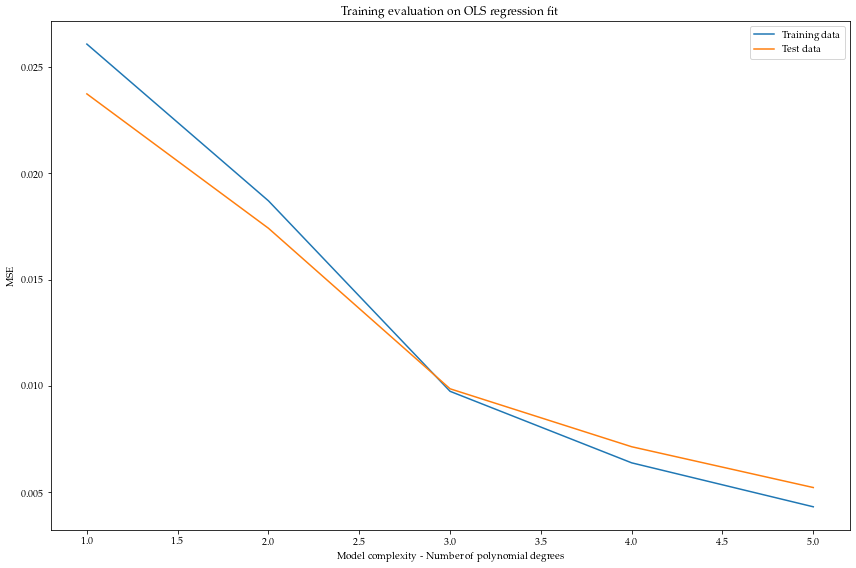

In [22]:
degrees = 5
z_train_OLS = pd.DataFrame()
z_hat_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()

# TODO: Must fix so that training and test data are used. 
# Must evalute model using MSE from traning and test
conf_df = pd.DataFrame()
for degree in range(1, degrees + 1):
    X = create_X(x, y, degree) # Design Matrix
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False, random_state=4155)
    model = OLS() # The model
    model.fit(X_train, z_train) # Fitting the model
    
    z_hat_train = model.predict(X_train) # predict on train data
    z_hat_test = model.predict(X_test) # predict on test data

    # Evaluatation metrics
    # TODO:
    sigma = np.sqrt(1/(X.shape[0] - X.shape[1] - 1) * np.sum((z_test - z_hat_test)**2))
    betas = model.get_all_betas()
    
    for i, beta in enumerate(betas):
        sigma_beta = sigma * np.sqrt(np.linalg.pinv(X.T @ X))[i,i]
        lower = beta - 1.966*sigma_beta
        upper = beta + 1.966*sigma_beta
        df = pd.DataFrame.from_dict({"lower_conf":lower, "upper_conf":upper, "beta": beta, "beta_no": f"beta{i+1}", "degree" :degree}, orient='index').T
        conf_df = pd.concat([conf_df,df], axis=0)

        
        #error = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
        #bias = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
        #variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )


    # Filling up dataframes
    z_train_OLS[degree] = z_train.flatten() 
    z_hat_train_OLS[degree] = z_hat_train.flatten()
    z_test_OLS[degree] = z_test.flatten()
    z_hat_test_OLS[degree] = z_hat_test.flatten()


# MSE calculations for all lambda values
mse_scores_train = ((z_train_OLS - z_hat_train_OLS) ** 2).mean()
mse_scores_test = ((z_test_OLS - z_hat_test_OLS) ** 2).mean()
# R2 calculations for all lambda values
R2_scores_train = 1 - ((z_train_OLS - z_hat_train_OLS) ** 2).sum() / ((z_train_OLS - z_train_OLS.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_OLS - z_hat_test_OLS) ** 2).sum() / ((z_test_OLS - z_test_OLS.mean())**2).sum()  

# Plots
plt.figure(figsize=(12,8))
plt.plot(np.arange(1,degrees+1), mse_scores_train, label="Training data")
plt.plot(np.arange(1,degrees+1), mse_scores_test, label="Test data")
plt.xlabel("Model complexity - Number of polynomial degrees")
plt.ylabel("MSE")
plt.title("Training evaluation on OLS regression fit")
plt.legend()
plt.tight_layout()
plt.savefig(f"{REPORT_FIGURES}franke_function_OLS_evaluate_fit.pdf")

## 1.4 Analysis of plots and training metrics
Do the analysis.......

Conclusion:<br>
Based on the analysis, we conclude that a model complexity of degree 5 yields the most optimal fit.

## 1.5 plot of the model using the most optimal parameters

In [ ]:
degree_optimal = 5
X = create_X(x, y, degree_optimal) # Design Matrix
model = OLS() # The model
model.fit(X, z) # Fitting the model
z_hat = model.predict(X) # predict on train data

# Plot
fig = plt.figure()#figsize=(8,8))
ax = plt.axes(projection='3d')
ax.title.set_text(f"OLS regression fit to the Franke Function\noptimal degree {degree_optimal},")
#ax.view_init(elev=5., azim=85.0)
ax.view_init(elev=30., azim=-25.0)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.scatter3D(y, x, z_hat, c=z_hat ,marker = '.', cmap=cm.coolwarm)
plt.savefig(f"{REPORT_FIGURES}franke_function_OLS_best_fit.pdf")

# 2 - Ridge Regression

## 2.1 Data
Defining and creating the data


In [ ]:
features = 6
#x = np.arange(0, 1, 0.05)
#y = np.arange(0, 1, 0.05)
X = create_X(x, y, n=features) # Design Matrix
z = FrankeFunction(x,y)
z += noise # Adding stochastic noise

## 2.3 - Finding optimal lambda for Ridge fit
First we find the optimal value for the lambda parameter by splitting the input data into training and test data. Than we fit the model using different values for lambda. For each lambda value we use the mean square error on the test data evaluate how god the fit is. The best lambda value is used to fit a new model with all data (not using train-test split). <br>
First we find the optimal parameter value of lambda, $\lambda$, by evaluating overfit from evaluation plot where we plot the values for MSE for training and test data

In [ ]:
nbf_lambdas = 100
lambdas = np.logspace(-6,6, nbf_lambdas)
z_train_ridge = pd.DataFrame()
z_hat_train_ridge = pd.DataFrame()
z_test_ridge = pd.DataFrame()
z_hat_test_ridge = pd.DataFrame()

for lam in lambdas:
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False, random_state=4155)
    model = RidgeRegression(lam) # The model
    model.fit(X_train, z_train) # Fitting the model
   
    # Predictions
    z_hat_train = model.predict(X_train) # predict on train data
    z_hat_test = model.predict(X_test) # predict on test data

    # Filling up dataframes
    z_train_ridge[lam] = z_train.flatten() 
    z_hat_train_ridge[lam] = z_hat_train.flatten()
    z_test_ridge[lam] = z_test.flatten()
    z_hat_test_ridge[lam] = z_hat_test.flatten()


# MSE calculations for all lambda values
mse_scores_train = ((z_train_ridge - z_hat_train_ridge) ** 2).mean()
mse_scores_test = ((z_test_ridge - z_hat_test_ridge) ** 2).mean()
# R2 calculations for all lambda values
R2_scores_train = 1 - ((z_train_ridge - z_hat_train_ridge) ** 2).sum() / ((z_train_ridge - z_train_ridge.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_ridge - z_hat_test_ridge) ** 2).sum() / ((z_test_ridge - z_test_ridge.mean())**2).sum()  

# Plots
plt.figure(figsize=(12,8))
plt.plot(-np.log(lambdas), mse_scores_train, label="Training data")
plt.plot(-np.log(lambdas), mse_scores_test, label="Test data")
#plt.plot(mse_scores_train,-np.log(lambdas), label="Training data")
#plt.plot(mse_scores_test,-np.log(lambdas), label="Test data")
plt.xlabel("log(lambda)")
plt.ylabel("MSE")
plt.title("Training evaluation on Ridge regression fit")
plt.legend()
plt.savefig(f"{REPORT_FIGURES}franke_function_Ridge_evaluate_fit.pdf")

## 2.4 Analysis of plots and training metrics
Do the analysis.......

Conclusion:<br>
Based on the analysis, we conclude that a model complexity of degree 5 yields the most optimal fit.

## 2.5 plot of the model using the most optimal parameters

In [ ]:
scale = False

if scale:
    # Data Scalling
    X_scaler = StandardScaler()
    X_scaler.fit(X)
    X_train = X_scaler.transform(X_train)
    z_train = np.expand_dims(z,axis=1)  
    z_scaler = StandardScaler()
    z_scaler.fit(z_train)
    z_train = z_scaler.transform(z_train)
else:
    X_train = X; z_train = z

lam = -1.1
model = RidgeRegression(lam) # The model
model.fit(X_train, z_train) # Fitting the model
z_hat = model.predict(X_train) # predict on train data

# Evaluatation metrics
# TODO:
results_df = pd.DataFrame(columns=["MSE", "R2-score"], index=["Training data", "Test data"])
results_df["MSE"] = MSE(z, z_hat)
results_df["R2-score"] = R2(z, z_hat)
results_df.to_csv(f"{REPORT_DATA}redge_reg_lambda_{lam}.csv")

# Plot
fig = plt.figure()#figsize=(8,8))
ax = plt.axes(projection='3d')
ax.title.set_text(f"Ridge regression fit to the Franke Function\nDegree {degree},$\lambda$:{lam}")
#ax.view_init(elev=5., azim=85.0)
ax.view_init(elev=30., azim=-25.0)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.scatter3D(x,y,z,c=z, cmap=cm.coolwarm, marker = '.')
plt.savefig(f"{REPORT_FIGURES}franke_function_Ridge_best_fit.pdf")